In [1]:
import json
import tabulate

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Faulty engine", 'Fixed by', "Code Size"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    table_data.append([
        test_name,
        metadata['engine'],
        metadata['fixed-by'],
        data['metadata']['code-size'],
        # metadata['function_count']
    ])
# Sort the table data by the original size code
table_data.sort(key=lambda row: row[3] if isinstance(row[3], (int, float)) else float('inf'))

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, intfmt=",", tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")

# Save the table to a file
print(f"Number of eval set: {len(table_data)}")
rq1_table_path = f'./table/eval_set.tex'
with open(rq1_table_path, 'w') as file:
    print(latex_table)
    file.write(latex_table)
    print(f"Table saved to {rq1_table_path}")

Number of eval set: 28
\begin{tabular}{lllr}
\hline
 Name            & Faulty engine   & Fixed by   &   Code Size \\
\hline
 wasmedge\#3018   & WasmEdge        & 93fd4ae    &       1,913 \\
 wamr\#2789       & WAMR            & 718f06     &      17,604 \\
 wasmedge\#3019   & WasmEdge        & 93fd4ae    &      19,098 \\
 wamr\#2862       & WAMR            & 0ee5ff     &      19,727 \\
 wamr\#2450       & WAMR            & e360b7     &      24,482 \\
 wasmedge\#3076   & WasmEdge        & 93fd4ae    &      31,365 \\
 mandelbrot      & Wizard          & 0b43b8     &      64,515 \\
 pathfinding     & Wizard          & ccf0c56    &     180,026 \\
 pacalc          & Wizard          & 81555ab    &     238,902 \\
 wasmedge\#3057   & WasmEdge        & 93fd4ae    &     243,564 \\
 guiicons        & Wizard          & 6d2b057    &     285,840 \\
 rtexviewer      & Wizard          & 708ea77    &     296,617 \\
 rfxgen          & Wizard          & 6d2b057    &     378,918 \\
 riconpacker     & Wizar

In [4]:
import json
import tabulate
from scipy.stats import gmean

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Input Code Size", "wasm-shrink Code Size", "RR-Reduce Code Size (Target Size)", "wasm-reduce Code Size", "wasm-hybrid Code Size"]

# size_to_use = 'module-size'
size_to_use = 'code-size'

lowest_tool = {}
for test_name, data in metrics.items():
    try:
        metadata = data['metadata']
        fixed_by = metadata.get('fixed-by')
        wrong_code = metadata.get('wrong-code')
        original_code_size = data['metadata'].get(size_to_use)
        wasm_shrink_code_size = data['wasm-shrink'].get('code-size')
        rr_reduce_code_size = data['wasm-slice'].get('code-size')
        rr_reduce_target_size = data['wasm-slice'].get('target-size')
        wasm_hybrid_all_code_size = data['wasm-hybrid'].get(size_to_use)
        wasm_reduce_code_size = data['wasm-reduce'].get(size_to_use)

        wasm_shrink_code_size_percentage = (wasm_shrink_code_size / original_code_size) * 100
        rr_reduce_code_size_percentage = (rr_reduce_code_size / original_code_size) * 100
        rr_reduce_target_size_percentage = (rr_reduce_target_size / original_code_size) * 100
        wasm_hybrid_all_code_size_percentage = (wasm_hybrid_all_code_size / original_code_size) * 100
        wasm_reduce_code_size_percentage = (wasm_reduce_code_size / original_code_size) * 100
        # Determine the tool with the lowest code size percentage
        min_percentage = min(wasm_shrink_code_size_percentage, rr_reduce_code_size_percentage, wasm_reduce_code_size_percentage, wasm_hybrid_all_code_size_percentage)
        lowest_tools = []
        if min_percentage == wasm_shrink_code_size_percentage:
            lowest_tools.append('wasm-shrink Code Size')
        if min_percentage == rr_reduce_code_size_percentage:
            lowest_tools.append('RR-Reduce Code Size')
        if min_percentage == wasm_reduce_code_size_percentage:
            lowest_tools.append('wasm-reduce Code Size')
        if min_percentage == wasm_hybrid_all_code_size_percentage:
            lowest_tools.append('wasm-hybrid Code Size')
        lowest_tool[test_name] = ', '.join(lowest_tools)

        table_data.append([
            test_name,
            original_code_size,
            f"{wasm_shrink_code_size_percentage:.4f}%",
            f"{rr_reduce_code_size_percentage:.4f}% ({rr_reduce_target_size_percentage:.4f}%)",
            f"{wasm_reduce_code_size_percentage:.4f}%",
            f"{wasm_hybrid_all_code_size_percentage:.4f}%"
        ])
    except Exception as e:
        print(test_name, data)
        print(e)
        continue
# Sort the table data by the original size
table_data.sort(key=lambda row: float(row[1]))

# Calculate geometric mean for the percentages
geomean_wasm_shrink = gmean([float(row[2].split('%')[0]) for row in table_data if row[2] != ""])
geomean_rr_reduce = gmean([float(row[3].split('%')[0]) for row in table_data if row[3] != ""])
geomean_rr_reduce_target = gmean([float(row[3].split('(')[1].split('%')[0]) for row in table_data if '(' in row[3]])
geomean_wasm_reduce = gmean([float(row[4].split('%')[0]) for row in table_data if row[4] != ""])
geomean_wasm_hybrid_all = gmean([float(row[5].split('%')[0]) for row in table_data if row[5] != ""])

# Append the geometric mean row
table_data.append([
    "Geomean",
    "",
    f"{geomean_wasm_shrink:.4f}%",
    f"{geomean_rr_reduce:.4f}% ({geomean_rr_reduce_target:.4f}%)",
    f"{geomean_wasm_reduce:.4f}%",
    f"{geomean_wasm_hybrid_all:.4f}%"
])

# Add geometric mean to lowest_tool
lowest_tool["Geomean"] = "wasm-hybrid Code Size"

# Make the lowest tool bold in the table
for row in table_data:
    test_name = row[0]
    if test_name in lowest_tool:
        tools = lowest_tool[test_name]
        for tool in tools.split(', '):
            tool_index = headers.index(tool)
            row[tool_index] = f"\\textbf{{{row[tool_index]}}}"

latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=".f")

# Escape percentage signs in the LaTeX table
latex_table = latex_table.replace('%', '\\%')

rq2_table_path = f'./table/rq1.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq2_table_path}")

\begin{tabular}{llllll}
\hline
 Name            & Input Code Size   & wasm-shrink Code Size   & RR-Reduce Code Size (Target Size)   & wasm-reduce Code Size   & wasm-hybrid Code Size   \\
\hline
 wasmedge#3018   & 1913              & 4.6524\%                 & 23.7324\% (17.0936\%)                 & 1.2546\%                 & \textbf{0.5750\%}        \\
 wamr#2789       & 17604             & \textbf{0.0511\%}        & 1.9087\% (0.1761\%)                   & \textbf{0.0511\%}        & \textbf{0.0511\%}        \\
 wasmedge#3019   & 19098             & 7.7128\%                 & 3.7491\% (0.9163\%)                   & \textbf{0.0628\%}        & \textbf{0.0628\%}        \\
 wamr#2862       & 19727             & 2.9503\%                 & 9.2716\% (7.1171\%)                   & \textbf{0.1825\%}        & \textbf{0.1825\%}        \\
 wamr#2450       & 24482             & 11.4819\%                & 3.3331\% (1.7278\%)                   & \textbf{0.0327\%}        & \textbf{0.0327\%}        \\
 

In [11]:
import json
from scipy.stats import gmean
import tabulate

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "RR-R (s)", "H-R (s)","W-R (s)", "W-S (s) "]

# Sort the metrics dictionary by the 'code-size' in the 'metadata' field
metrics = dict(sorted(metrics.items(), key=lambda item: item[1]['metadata'].get('code-size', float('inf'))))

for test_name, data in metrics.items():
    try:
        metadata = data['metadata']
        # fixed_by = metadata.get('fixed-by')
        # original_size = data['metadata'].get('code-size')
        rr_reduce_time = float(data['wasm-slice'].get('time'))
        wasm_hybrid_all_time = float(data['wasm-hybrid'].get('time'))
        wasm_reduce_time = float(data['wasm-reduce'].get('time'))
        wasm_shrink_time = float(data['wasm-shrink'].get('time'))
        table_data.append([
            test_name,
            # fixed_by,
            # original_size,
            rr_reduce_time,
            wasm_hybrid_all_time,
            wasm_reduce_time,
            wasm_shrink_time,
        ])
    except Exception as e:
        print(e)
        continue

# Calculate geometric mean for the times
geomean_rr_reduce_time = gmean([row[1] for row in table_data])
geomean_wasm_hybrid_all_time = gmean([row[2] for row in table_data])
geomean_wasm_reduce_time = gmean([row[3] for row in table_data])
geomean_wasm_shrink_time = gmean([row[4] for row in table_data])

# Append the geometric mean row
table_data.append([
    "Geomean",
    geomean_rr_reduce_time,
    geomean_wasm_hybrid_all_time,
    geomean_wasm_reduce_time,
    geomean_wasm_shrink_time
])

latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=",.0f")

rq2_table_path = f'./table/rq2.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq2_table_path}")

\begin{tabular}{lrrrr}
\hline
 Name            &   RR-R (s) &   H-R (s) &   W-R (s) &   W-S (s)  \\
\hline
 wasmedge#3018   &         35 &        49 &        23 &        170 \\
 wamr#2789       &        600 &       610 &         6 &         24 \\
 wasmedge#3019   &         33 &        53 &     4,195 &         10 \\
 wamr#2862       &        506 &       309 &        54 &        300 \\
 wamr#2450       &         78 &        80 &        31 &         35 \\
 wasmedge#3076   &      1,112 &       891 &     1,017 &     86,400 \\
 mandelbrot      &        202 &    73,069 &    71,808 &     15,178 \\
 pathfinding     &      1,505 &     1,707 &     3,627 &      3,722 \\
 pacalc          &         31 &    23,287 &     1,014 &        616 \\
 wasmedge#3057   &      3,967 &     4,150 &     2,599 &     86,400 \\
 guiicons        &        105 &    20,216 &    29,266 &      1,285 \\
 rtexviewer      &        943 &       978 &       197 &        745 \\
 rfxgen          &        166 &    12,867 &     9,475

Error processing wasmedge#3018: 'wasm-hybrid-all'
Error processing wamr#2789: 'wasm-hybrid-all'
Error processing wamr#2450: 'wasm-hybrid-all'
Error processing wamr#2862: 'wasm-hybrid-all'
Error processing wasmedge#3019: 'wasm-hybrid-all'
Error processing wasmedge#3076: 'wasm-hybrid-all'
Error processing mandelbrot: 'wasm-hybrid-all'
Error processing guiicons: 'wasm-hybrid-all'
Error processing rguilayout: 'wasm-hybrid-all'
Error processing rguistyler: 'wasm-hybrid-all'
Error processing riconpacker: 'wasm-hybrid-all'
Error processing rfxgen: 'wasm-hybrid-all'
Error processing rtexviewer: 'wasm-hybrid-all'
Error processing wasmedge#3057: 'wasm-hybrid-all'
Error processing funky-kart: 'wasm-hybrid-all'
Error processing hydro: 'wasm-hybrid-all'
Error processing sqlgui: 'wasm-hybrid-all'
Error processing commanderkeen: 'wasm-hybrid-all'
Error processing boa: 'wasm-hybrid-all'
Error processing jsc: 'wasm-hybrid-all'
Error processing pacalc: 'wasm-hybrid-all'
Error processing bullet: 'wasm-hy

/tmp/ipykernel_463245/38162543.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([wasm_slice_sizes, wasm_shrink_sizes, wasm_slice_target_sizes, wasm_reduce_sizes, wasm_hybrid_all_sizes],


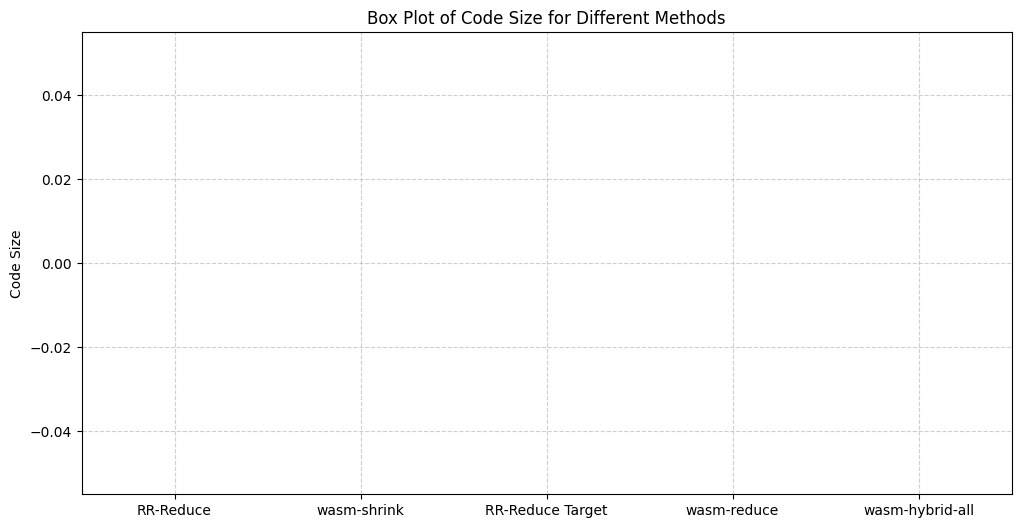

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# size_to_use = "module-size"
size_to_use = "code-size"

# Collecting code size data
wasm_reduce_sizes = []
wasm_shrink_sizes = []
wasm_slice_target_sizes = []
wasm_slice_sizes = []
wasm_hybrid_all_sizes = []

test_names = []

for test_name, data in metrics.items():
    try:
        wasm_reduce_code_size = data['wasm-reduce'].get(size_to_use)
        wasm_shrink_code_size = data['wasm-shrink'].get(size_to_use)
        wasm_slice_target_size = data['wasm-slice'].get('target-size')
        wasm_slice_code_size = data['wasm-slice'].get(size_to_use)
        wasm_hybrid_all_code_size = data['wasm-hybrid-all'].get(size_to_use)

        if wasm_shrink_code_size is not None and wasm_reduce_code_size is not None and wasm_slice_target_size is not None and  wasm_slice_code_size is not None and wasm_hybrid_all_code_size is not None:
            test_names.append(test_name)
            wasm_shrink_sizes.append(wasm_shrink_code_size)
            wasm_reduce_sizes.append(wasm_reduce_code_size)
            wasm_slice_target_sizes.append(wasm_slice_target_size)
            wasm_slice_sizes.append(wasm_slice_code_size)
            wasm_hybrid_all_sizes.append(wasm_hybrid_all_code_size)
    except Exception as e:
        print(f"Error processing {test_name}: {e}")

# Ensure we have valid numerical data
wasm_reduce_sizes = sorted(wasm_reduce_sizes)
wasm_shrink_sizes = sorted(wasm_shrink_sizes)
wasm_slice_target_sizes = sorted(wasm_slice_target_sizes)
wasm_slice_sizes = sorted(wasm_slice_sizes)
wasm_hybrid_all_sizes = sorted(wasm_hybrid_all_sizes)
print("Wasm Shrink Sizes:", wasm_shrink_sizes)
print("Wasm Reduce Sizes:", wasm_reduce_sizes)
print("Wasm Slice Target Sizes:", wasm_slice_target_sizes)
print("Wasm Slice Sizes:", wasm_slice_sizes)
print("Wasm Hybrid All Sizes:", wasm_hybrid_all_sizes)
plt.figure(figsize=(12, 6))

# Create box plots side by side
plt.boxplot([wasm_slice_sizes, wasm_shrink_sizes, wasm_slice_target_sizes, wasm_reduce_sizes, wasm_hybrid_all_sizes],
            vert=True, patch_artist=True,
            labels=['RR-Reduce', 'wasm-shrink', 'RR-Reduce Target', "wasm-reduce", "wasm-hybrid-all"],
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='blue', linewidth=1.5),
            capprops=dict(color='blue', linewidth=1.5))

plt.ylabel("Code Size")
plt.title("Box Plot of Code Size for Different Methods")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()